Here, we ensure that we can store arbitrary types as attribute values - not just strings - for efficiency.  The builtin serialization only works with strings, but supplying our own serialization isn't objectionable.

In [1]:
import copy
import xml.etree.ElementTree as xml

import graphcat.notebook

In [2]:
def append_element(graph, name, inputs):
    parent = copy.copy(inputs.getone("parent"))
    child = inputs.getone("child")
    parent.append(child)
    return parent


def create_element(tag, attrib={}, **extra):
    def implementation(graph, name, inputs):
        return xml.Element(tag, attrib=attrib, **extra)
    return implementation

def dump(element, level=0):
    indent = "  " * level
    attributes = "".join(f" {key}=\"{str(value)}\"" for key, value in element.items())
    print(f"{indent}<{element.tag}{attributes}>")
    for child in element:
        dump(child, level+1)
    print(f"{indent}</{element.tag}>")

In [3]:
graph = graphcat.StaticGraph()
graph.add_task("canvas", create_element("canvas", width=200, height=5.4, style="foo"))
graph.add_task("axes1", create_element("cartesian"))
graph.add_task("append1", append_element)
graph.add_links("canvas", ("append1", "parent"))
graph.add_links("axes1", ("append1", "child"))

graph.add_task("axes2", create_element("radial"))
graph.add_task("append2", append_element)
graph.add_links("append1", ("append2", "parent"))
graph.add_links("axes2", ("append2", "child"))

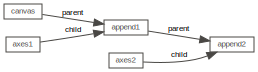

In [4]:
graphcat.notebook.display(graph)

In [5]:
dump(graph.output("append2"))

<canvas width="200" height="5.4" style="foo">
  <cartesian>
  </cartesian>
  <radial>
  </radial>
</canvas>


In [6]:
graph.output("append2").attrib["height"]

5.4

Here, we confirm that the attribute dictionary is shared between shallow-copied elements:

In [7]:
assert(id(graph.output("canvas").attrib) == id(graph.output("append1").attrib))

We also ensure that we can override attributes without modifying the upstream originals:

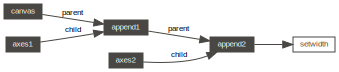

In [8]:
def set_attribute(key, value):
    def implementation(graph, name, inputs):
        original = inputs.getone(None)
        modified = xml.Element(original.tag, attrib=original.attrib)
        for child in original:
            modified.append(child)
        modified.set(key, value)
        return modified
    return implementation
    
graph.add_task("setwidth", set_attribute("width", 300))
graph.add_links("append2", "setwidth")

graphcat.notebook.display(graph)


In [9]:
dump(graph.output("append2"))

<canvas width="200" height="5.4" style="foo">
  <cartesian>
  </cartesian>
  <radial>
  </radial>
</canvas>


In [10]:
dump(graph.output("setwidth"))

<canvas width="300" height="5.4" style="foo">
  <cartesian>
  </cartesian>
  <radial>
  </radial>
</canvas>


In [11]:
assert(id(graph.output("append2")) != id(graph.output("setwidth")))
assert(id(graph.output("append2").attrib) != id(graph.output("setwidth").attrib))

for lhs, rhs in zip(graph.output("append2"), graph.output("setwidth")):
    assert(id(lhs) == id(rhs))